In [1]:
import torch
import sys
import numpy as np
import cv2
from matplotlib import pyplot as plt

def inference_with_patches(model, image, device='cpu'):
    """
    Inference su immagine 800x800 divisa in due patch: centro 416x416 e cornice esterna.

    Parameters
    ----------
    model : nn.Module
        Modello UNet addestrato.
    image : np.array shape (800, 800)
        Immagine normalizzata float32 (0-1).
    device : str
        'cpu' o 'cuda'.

    Returns
    -------
    final_heatmap : np.array (800, 800)
        Heatmap ricostruita con output probabilistici.
    """

    model.eval()
    model.to(device)

    h, w = image.shape
    assert h == 800 and w == 800, "Immagine deve essere 800x800"

    cx, cy = w // 2, h // 2
    half_patch = 416 // 2

    # Estraggo patch centro e cornice
    patch_center = image[cy - half_patch:cy + half_patch, cx - half_patch:cx + half_patch]
    patch_frame = image.copy()
    patch_frame[cy - half_patch:cy + half_patch, cx - half_patch:cx + half_patch] = 0

    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    input_center = to_tensor(patch_center)
    input_frame = to_tensor(patch_frame)

    with torch.no_grad():
        out_center = torch.sigmoid(model(input_center)).cpu().squeeze().numpy()  # (416,416)
        out_frame = torch.sigmoid(model(input_frame)).cpu().squeeze().numpy()    # (800,800)

    # Ricostruzione heatmap finale
    final_heatmap = out_frame.copy()
    final_heatmap[cy - half_patch:cy + half_patch, cx - half_patch:cx + half_patch] = out_center

    return final_heatmap


import sys
sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

In [2]:
from UNet import UNet, load_keypoints_from_csv

directory = '/user/gr1/delphi/dghezzi/UNet/UNet_dataset/4000_1000_160_180_npy'

image = np.load(f'{directory}/images/val/event_5.npy')  # (800, 800) float32 normalizzato 0-1
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load('best_unet_patch.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu'))

final_heatmap = inference_with_patches(model, image, device='cuda')
final_heatmap = torch.sigmoid(torch.tensor(final_heatmap)).numpy()

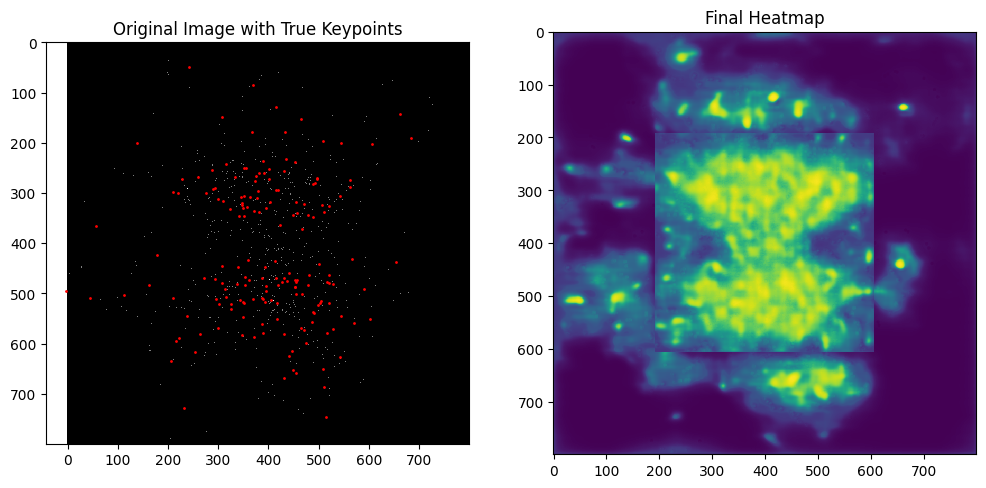

In [3]:
# printa le immagini
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.title('Final Heatmap')
plt.imshow(final_heatmap, cmap='viridis', interpolation='nearest')

plt.subplot(1, 2, 1)
plt.title('Original Image with True Keypoints')
plt.imshow(image, cmap='gray', interpolation='nearest')
keypoints = load_keypoints_from_csv(f'{directory}/centers/val/event_5_centers.csv')
for x, y in keypoints:
    plt.plot(x, y, '.', markersize=2, color='red')
plt.show()